### SetUp

In [24]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from tensorflow.keras.preprocessing.sequence import pad_sequences
keras = tf.keras

### Get the dataset

In [25]:
data_path = '/home/login/Documents/Machine_learning/Datasets/reviews/reviews.csv'
dataset = pd.read_csv(data_path, index_col = "Unnamed: 0")

sentences = dataset['text'].tolist()
labels = dataset['sentiment'].tolist()
len(sentences)

1992

### Create a subwords Dataset

In [26]:
vocab_size = 1000
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    sentences, vocab_size, max_subword_length = 5
)
print("Vocab size is ", tokenizer.vocab_size)

Vocab size is  999


In [27]:
# check tokenizer works properly
num = 5
print(sentences[num])

encoded = tokenizer.encode(sentences[num])
print(encoded)

for _ in encoded:
    print(tokenizer.decode([_]))

I have to jiggle the plug to get it to line up right to get decent volume.
[4, 31, 6, 849, 162, 450, 12, 1, 600, 438, 775, 6, 175, 14, 6, 55, 213, 159, 474, 775, 6, 175, 614, 380, 295, 148, 72, 789]
I 
have 
to 
j
ig
gl
e 
the 
pl
ug
 
to 
get 
it 
to 
li
ne 
up 
right
 
to 
get 
dec
ent 
vo
lu
me
.


### Replace sentence data with encoded subwords

In [28]:
for i, sentence in enumerate(sentences):
    sentences[i] = tokenizer.encode(sentence)

In [29]:
print(sentences[3])

[827, 187, 11, 6, 143, 63, 17, 79, 227, 594, 331, 3, 660, 26, 313, 182, 795, 415, 374, 60, 789, 820, 808, 817, 822, 825, 775, 823, 825, 822, 809, 819, 812, 820, 826, 263]


### Final Preprocessing

In [30]:
max_length = 50
padding_type = "post"
trunc_type = "post"

sequences_padded = pad_sequences(sentences, maxlen = max_length,
                                truncating = trunc_type, padding = padding_type)

train_size = int(len(labels) * 0.8)

train_sequences = sequences_padded[:train_size]
test_sequences = sequences_padded[train_size:]
train_labels = labels[:train_size]
test_labels = labels[train_size:]

train_labels_finals = np.array(train_labels)
test_labels_finals = np.array(test_labels)

### Create a model using Embedding

In [31]:
embedding_dim = 16

model = keras.models.Sequential([
    keras.layers.Embedding(vocab_size, embedding_dim, input_length = max_length),
    keras.layers.GlobalAveragePooling1D(),
    keras.layers.Dense(6, activation = 'relu'),
    keras.layers.Dense(1, activation = 'sigmoid')
])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 50, 16)            16000     
                                                                 
 global_average_pooling1d_1  (None, 16)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_8 (Dense)             (None, 6)                 102       
                                                                 
 dense_9 (Dense)             (None, 1)                 7         
                                                                 
Total params: 16109 (62.93 KB)
Trainable params: 16109 (62.93 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Train the model

In [32]:
EPOCHS = 30

model.compile(loss = keras.losses.BinaryCrossentropy(),
             optimizer = keras.optimizers.Adam(),
             metrics = ['accuracy'])

history = model.fit(train_sequences, train_labels_finals,
                   epochs = EPOCHS,
                   validation_data = (test_sequences, test_labels_finals))

Epoch 1/30
50/50 [==============================] - 1s 6ms/step - loss: 0.6916 - accuracy: 0.5173 - val_loss: 0.7001 - val_accuracy: 0.4110
Epoch 2/30
50/50 [==============================] - 0s 4ms/step - loss: 0.6871 - accuracy: 0.5267 - val_loss: 0.6965 - val_accuracy: 0.4336
Epoch 3/30
50/50 [==============================] - 0s 4ms/step - loss: 0.6808 - accuracy: 0.5562 - val_loss: 0.6943 - val_accuracy: 0.4586
Epoch 4/30
50/50 [==============================] - 0s 4ms/step - loss: 0.6679 - accuracy: 0.6070 - val_loss: 0.6881 - val_accuracy: 0.4862
Epoch 5/30
50/50 [==============================] - 0s 4ms/step - loss: 0.6476 - accuracy: 0.6409 - val_loss: 0.6686 - val_accuracy: 0.5464
Epoch 6/30
50/50 [==============================] - 0s 3ms/step - loss: 0.6198 - accuracy: 0.7137 - val_loss: 0.6470 - val_accuracy: 0.6266
Epoch 7/30
50/50 [==============================] - 0s 3ms/step - loss: 0.5853 - accuracy: 0.7633 - val_loss: 0.6227 - val_accuracy: 0.6692
Epoch 8/30
50/50 [==

### Plot the accuracy and loss

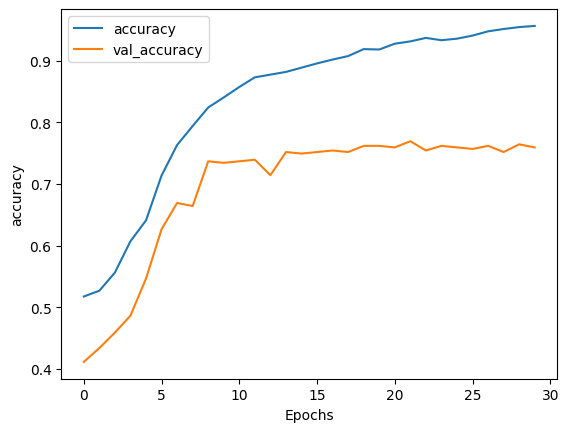

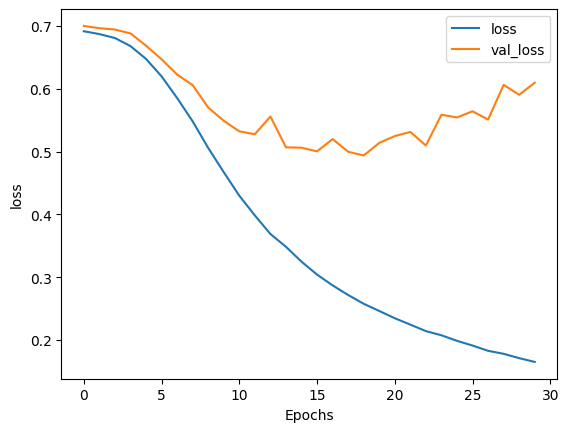

In [33]:
def plot_graphs(history, string):
    val_str = f"val_{string}"
    
    plt.plot(history.history[string])
    plt.plot(history.history[val_str])
    plt.legend([string, val_str])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.show()
    
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

### Define a function to predict the sentiment of reviews

In [34]:
def predict_review(model, new_sentences, maxlen = max_length, show_padded_sequence = True):
    new_encoded = []
    
    # convert the new reviews to sequences
    for i, sentence in enumerate(new_sentences):
        new_encoded.append(tokenizer.encode(sentence))
    
    trunc = 'post'
    padding = 'post'
    
    new_reviews_padded = pad_sequences(new_encoded, maxlen = max_length,
                                      padding = padding, truncating = trunc)
    
    predictions = model.predict(new_reviews_padded)
    
    for _ in range(len(new_sentences)):
        if show_padded_sequence:
            print(new_reviews_padded[_])
            
        print(new_sentences[_])
        print(predictions[_], end = "\n\n")

In [35]:
fake_reviews = ["I love this phone",
               "Everything was cold",
               "Everything was hot as I wanted",
               "Everything was green",
               "the host seated us immediately",
               "they gave us free chocolate cake",
               "we couldn't hear each other talk because of the shouting in the kitchen"]

predict_review(model, fake_reviews)

1/1 [==============================] - 0s 59ms/step
[  4 281  16  25   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
I love this phone
[0.93660426]

[812 227 864 100 775   9 525 843   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Everything was cold
[0.12401526]

[812 227 864 100 775   9 109   8  61   4 171  59  77   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Everything was hot as I wanted
[0.08878414]

[812 227 864 100 775   9 157 359 853   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Everything was green


### Define a function to train and show the results of models with different layers

In [36]:
def fit_model_and_show_results(model, sentences):
    model.compile(loss = keras.losses.BinaryCrossentropy(),
                 optimizer = keras.optimizers.Adam(),
                 metrics = ['accuracy'])
    
    model.summary()
    history = model.fit(train_sequences, train_labels_finals, epochs = EPOCHS,
                       validation_data = (test_sequences, test_labels_finals))
    
    plot_graphs(history, "accuracy")
    plot_graphs(history, "loss")
    
    predict_review(model, sentences)

### Add a bidirectional LSTM model

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 50, 16)            16000     
                                                                 
 bidirectional_4 (Bidirecti  (None, 32)                4224      
 onal)                                                           
                                                                 
 dense_10 (Dense)            (None, 6)                 198       
                                                                 
 dense_11 (Dense)            (None, 1)                 7         
                                                                 
Total params: 20429 (79.80 KB)
Trainable params: 20429 (79.80 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/30
50/50 [==============================] - 7s 47ms/step - loss: 0.6910 - ac

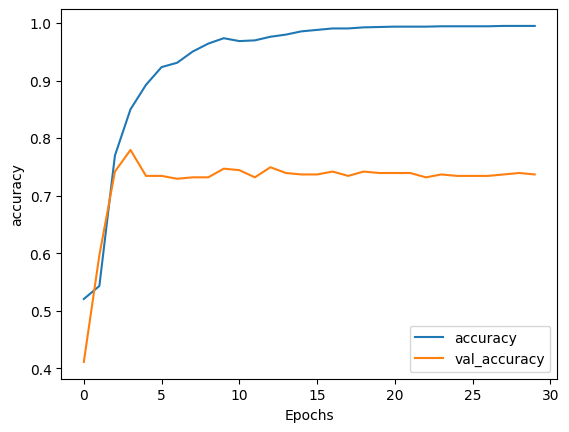

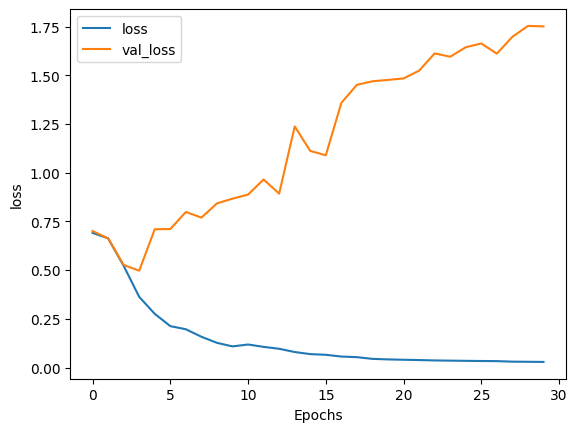

1/1 [==============================] - 2s 2s/step
[  4 281  16  25   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
I love this phone
[0.99977386]

[812 227 864 100 775   9 525 843   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Everything was cold
[0.01269232]

[812 227 864 100 775   9 109   8  61   4 171  59  77   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Everything was hot as I wanted
[0.0177664]

[812 227 864 100 775   9 157 359 853   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Everything was green
[0.

In [37]:
model_bi_lstm = keras.models.Sequential([
    keras.layers.Embedding(vocab_size, embedding_dim, input_length = max_length),
    keras.layers.Bidirectional(keras.layers.LSTM(embedding_dim)),
    keras.layers.Dense(6, activation = 'relu'),
    keras.layers.Dense(1, activation = 'sigmoid')
])

fit_model_and_show_results(model_bi_lstm, fake_reviews)

### Use multiple bidirectional layers

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 50, 16)            16000     
                                                                 
 bidirectional_5 (Bidirecti  (None, 50, 32)            4224      
 onal)                                                           
                                                                 
 bidirectional_6 (Bidirecti  (None, 32)                6272      
 onal)                                                           
                                                                 
 dense_12 (Dense)            (None, 6)                 198       
                                                                 
 dense_13 (Dense)            (None, 1)                 7         
                                                                 
Total params: 26701 (104.30 KB)
Trainable params: 2670

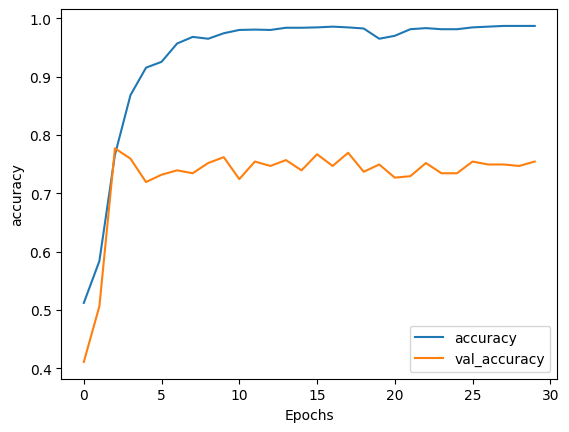

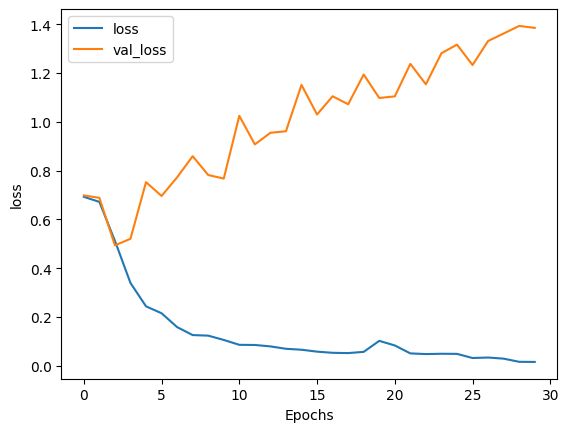

1/1 [==============================] - 2s 2s/step
[  4 281  16  25   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
I love this phone
[0.9992678]

[812 227 864 100 775   9 525 843   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Everything was cold
[0.01175094]

[812 227 864 100 775   9 109   8  61   4 171  59  77   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Everything was hot as I wanted
[0.00376106]

[812 227 864 100 775   9 157 359 853   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Everything was green
[0.

In [38]:
model_mult_bi_lstm = keras.models.Sequential([
    keras.layers.Embedding(vocab_size, embedding_dim, input_length = max_length),
    keras.layers.Bidirectional(keras.layers.LSTM(embedding_dim, 
                                                return_sequences = True)),
    keras.layers.Bidirectional(keras.layers.LSTM(embedding_dim)),
    keras.layers.Dense(6, activation = 'relu'),
    keras.layers.Dense(1, activation = 'sigmoid')
])

fit_model_and_show_results(model_mult_bi_lstm, fake_reviews)

### Compare predictions for all models

##### Embeddings and GlobalAveragePooling
##### Embeddings and a Bidirectional LSTM layer
##### Embeddings and a multiple Bidirectional LSTM layer

In [39]:
my_reviews = [
    "lovely", "dreadful", "stay away", 
    "everything was hot exactly as I wanted",
    "everything was not exactly as I wanted",
    "they gave us free chocolate cake",
    "I've never eaten anything so spicy in my life, my throat burned for hours",
    "for a phone that is as expensive as this one I expect it to be much easier to use than this thing is",
    "we left there very full for a low price so I'd say you just can't go wrong at this place", 
    "that place does not have quality meals and isn't a good place to go for dinner"
]

In [40]:
print("====================\n", "Embeddings only: \n", "====================")
predict_review(model, my_reviews, show_padded_sequence = False)

print("====================\n", "With a single bidirectional LSTM: \n", "====================")
predict_review(model_bi_lstm, my_reviews, show_padded_sequence = False)

print("====================\n", "With two bidirectional LSTM: \n", "====================")
predict_review(model_mult_bi_lstm, my_reviews, show_padded_sequence = False)

 Embeddings only: 
1/1 [==============================] - 0s 21ms/step
lovely
[0.95082605]

dreadful
[0.34031802]

stay away
[0.70224226]

everything was hot exactly as I wanted
[0.81804717]

everything was not exactly as I wanted
[0.5144799]

they gave us free chocolate cake
[0.80622214]

I've never eaten anything so spicy in my life, my throat burned for hours
[0.05121295]

for a phone that is as expensive as this one I expect it to be much easier to use than this thing is
[0.37546426]

we left there very full for a low price so I'd say you just can't go wrong at this place
[0.7826293]

that place does not have quality meals and isn't a good place to go for dinner
[0.9043222]

 With a single bidirectional LSTM: 
1/1 [==============================] - 0s 21ms/step
lovely
[0.9984138]

dreadful
[0.01112299]

stay away
[0.03372754]

everything was hot exactly as I wanted
[0.9873091]

everything was not exactly as I wanted
[0.01539766]

they gave us free chocolate cake
[0.8899521]

I've n